# NYC Bike Rental Graphical Neural Network Analysis



## Set up

### Import and Mounting

In [48]:
from google.colab import drive

drive.mount('/content/drive') # Remember to add the folder (as a shortcut) to your drive before running this cell
%cd /content/drive/MyDrive/PROJECT_CS547_IE534

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1ebKvoK7afoaMA3BiVP8gBiRPCDUjeorO/PROJECT_CS547_IE534


In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math

This installs `torch_geometric`

In [50]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [51]:
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

### Data preprocessing

Get the data from the Google Drive folder

In [52]:
# Load training data (with one-hot encoding and without)
training_with_onehot = pd.read_pickle('./Milestone_1/training_data_with_onehot.pkl').reset_index(drop=True)
training_without_onehot = pd.read_pickle('./Milestone_1/training_data_without_onehot.pkl').reset_index(drop=True)

# Target and features
TARGET = 'end_station_name'  # Target variable

In [53]:
df = training_without_onehot

In [54]:
df.head()

,rideable_type,started_at,Month,Day_of_Week,Exact_start_Time,ended_at,duration,start_station_name,start_lat,start_lng,member_casual,Weather_PRCP,Weather_AVG_WIND,Weather_TMAX,Weather_TMIN,Weather_SNOW,end_station_name,end_lat,end_lng
0,classic_bike,2023-01-09 18:45:11.355,January,Monday,18:45:11.355000,2023-01-09 18:52:51.173,459.818,Broadway & W 56 St,40.765265,-73.981923,member,0.01,4.47,44.0,37.0,0.0,E 54 St & 1 Ave,40.756265,-73.964179
1,classic_bike,2023-01-24 21:59:02.412,January,Tuesday,21:59:02.412000,2023-01-24 22:01:46.344,163.932,Kingston Ave & Herkimer St,40.678907,-73.941428,member,0.23,NaN,NaN,NaN,0.0,MacDonough St & Marcy Ave,40.680780,-73.946130
2,classic_bike,2023-01-06 05:36:46.608,January,Friday,05:36:46.608000,2023-01-06 05:53:27.805,1001.197,6 Ave & Broome St,40.724310,-74.004730,member,0.34,0.89,57.0,57.0,0.0,Broadway & W 48 St,40.760177,-73.984868
3,classic_bike,2023-01-17 09:32:14.431,January,Tuesday,09:32:14.431000,2023-01-17 10:00:05.335,1670.904,E 39 St & 2 Ave,40.748033,-73.973828,member,0.00,3.13,47.0,35.0,0.0,W 17 St & 7 Ave,40.740564,-73.998526
4,classic_bike,2023-01-27 18:35:40.665,January,Friday,18:35:40.665000,2023-01-27 18:43:48.903,488.238,6 Ave & W 33 St,40.749013,-73.988484,casual,0.00,5.82,44.0,35.0,0.0,6 Ave & W 45 St,40.756951,-73.982631


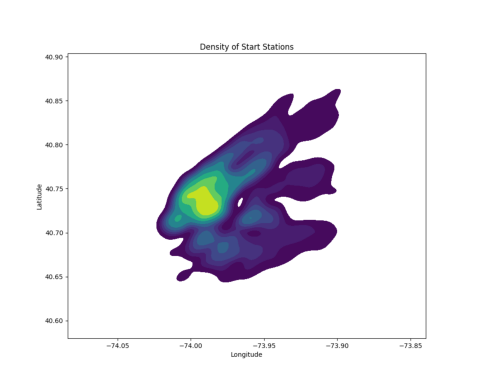

In [55]:
# Extract latitude and longitude for start stations
start_station_locations = df[['start_lat', 'start_lng']].dropna()

image_path = './Milestone_3/density_plot.png'
create_new_image = False

if create_new_image:
  if os.path.exists(image_path):
    os.remove(image_path)

  # Create the density plot
  plt.figure(figsize=(10, 8))
  sns.kdeplot(x=start_station_locations['start_lng'], y=start_station_locations['start_lat'], cmap="viridis", fill=True, thresh=0.05)
  plt.title('Density of Start Stations')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.savefig('density_plot.png')
  plt.show()
else:
  if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


This is a density plot of the starting locations of the bike rentals.

Makes `edge_index` maps between the rides start and end destinations.

In [56]:
start_stations = set(df['start_station_name'].unique())
end_stations = set(df[TARGET].unique())
total_stations = start_stations.union(end_stations)
print("Total Number of Stations:", len(total_stations))

Total Number of Stations: 2181


In [57]:
#make a map of total_stations to unique integers

station_to_int = {station: i for i, station in enumerate(total_stations)}
int_to_station = {i: station for i, station in enumerate(total_stations)}

In [58]:
df['start_station_index'] = df['start_station_name'].map(station_to_int)
df['end_station_index'] = df['end_station_name'].map(station_to_int)

Encodes the time features cyclically to be used in the model. Time of the day has a periodic or cyclical nature. Encoding it in this way preserves the cyclical structure, which would otherwise be lost with linear representations.

In [59]:
def encode_time_cyclically(datetime_series):
  hours = datetime_series.dt.hour
  minutes = datetime_series.dt.minute
  seconds = datetime_series.dt.second

  fraction_of_day = (hours + minutes / 60 + seconds / 3600) / 24
  sin_time = np.sin(2 * np.pi * fraction_of_day)
  cos_time = np.cos(2 * np.pi * fraction_of_day)

  return sin_time, cos_time

In [60]:
df['start_time_sin'], df['start_time_cos'] = encode_time_cyclically(df['started_at'])
df['end_time_sin'], df['end_time_cos'] = encode_time_cyclically(df['ended_at'])

In [61]:
df = df.rename(columns={'member_casual':'member_status'})
df = pd.get_dummies(df, columns=['rideable_type', 'Month', 'Day_of_Week', 'member_status'], dtype=float)

Forward fills the missing weather data since the data is ordered by time.

In [62]:
df['Weather_PRCP'] = df['Weather_PRCP'].ffill()
df['Weather_SNOW'] = df['Weather_SNOW'].ffill()
df['Weather_AVG_WIND'] = df['Weather_AVG_WIND'].ffill()
df['Weather_TMAX'] = df['Weather_TMAX'].ffill()
df['Weather_TMIN'] = df['Weather_TMIN'].ffill()

In [63]:
print(df.isna().sum())

started_at                     0
Exact_start_Time               0
ended_at                       0
duration                       0
start_station_name             0
start_lat                      0
start_lng                      0
Weather_PRCP                   0
Weather_AVG_WIND               0
Weather_TMAX                   0
Weather_TMIN                   0
Weather_SNOW                   0
end_station_name               0
end_lat                        0
end_lng                        0
start_station_index            0
end_station_index              0
start_time_sin                 0
start_time_cos                 0
end_time_sin                   0
end_time_cos                   0
rideable_type_classic_bike     0
rideable_type_electric_bike    0
Month_April                    0
Month_August                   0
Month_December                 0
Month_February                 0
Month_January                  0
Month_July                     0
Month_June                     0
Month_Marc

Normalizes the numerical features

In [64]:
features_to_normalize = ['duration', 'Weather_PRCP',
       'Weather_AVG_WIND', 'Weather_TMAX', 'Weather_TMIN', 'Weather_SNOW']

scaler = StandardScaler()
df.loc[:, features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [ ]:
node_features_list = ['start_lat', 'start_lng', 'duration', 'Weather_PRCP',
       'Weather_AVG_WIND', 'Weather_TMAX', 'Weather_TMIN', 'Weather_SNOW',
       'start_time_sin', 'start_time_cos', 'end_time_sin', 'end_time_cos',
       'rideable_type_classic_bike', 'rideable_type_electric_bike',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September',
       'Day_of_Week_Friday', 'Day_of_Week_Monday', 'Day_of_Week_Saturday',
       'Day_of_Week_Sunday', 'Day_of_Week_Thursday', 'Day_of_Week_Tuesday',
       'Day_of_Week_Wednesday', 'member_status_casual',
       'member_status_member']
edge_index_list = ['start_station_index', 'end_station_index']
target_feature_list = ['end_lat', 'end_lng']

We will be targeting the ending latitude and longitude of the bikes based on the starting points of the ride. Given the large cardinality of the set of stations, we are predicting any kind of accuracy measure where our model will try to predict the exact ending station will be very low. Additionally, the stations do no have many differences between them which makes classification even more difficult.

That is why the target features will be the ending latitude and longitude. This will allow for the model to possibly capture more differences between the stations and for a loss function to have more refined gradients.

If we wanted to create a classifier after our model has been trained, to possibly make accuracy meterics we can use the output of our model and then map the output of latitude and longitude to the closest station.

Separates data for the model

In [83]:
node_features = torch.tensor(df[node_features_list].values, dtype=torch.float)
edge_index = torch.tensor(df[edge_index_list].values, dtype=torch.int64)
target_features = torch.tensor(df[target_feature_list].values, dtype=torch.float)

In [84]:
data = Data(x=node_features, edge_index=edge_index.t().contiguous(), y=target_features)

## Basic Model

In [85]:
class BasicGCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels):
    super(BasicGCN, self).__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.fc = torch.nn.Linear(hidden_channels, 2)

  def forward(self, x, edge_index):

    x = F.relu(self.conv1(x, edge_index))
    x = F.relu(self.conv2(x, edge_index))

    x = self.fc(x)
    return x

In [86]:
def train(model, data, optimizer, criterion, epochs=100, verbose=False):
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if (verbose and epoch % 10 == 0) or epoch == epochs - 1:
      print(f'Epoch {epoch}, Loss: {loss.item()}')
  return model

In [87]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
epochs = 100

In [89]:
model = train(model, data, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 3399.701904296875
Epoch 10, Loss: 597.7347412109375
Epoch 20, Loss: 188.01138305664062
Epoch 30, Loss: 46.74632263183594
Epoch 40, Loss: 12.179874420166016
Epoch 50, Loss: 13.32051944732666
Epoch 60, Loss: 11.669631004333496
Epoch 70, Loss: 10.884716987609863
Epoch 80, Loss: 10.818310737609863
Epoch 90, Loss: 10.734662055969238
Epoch 99, Loss: 10.63655948638916


## Metric Creation

Create Station to lat-lng dictionary

In [ ]:
stations = pd.concat([
    df[['start_station_name', 'start_lat', 'start_lng']].rename(columns={
        'start_station_name': 'station_name',
        'start_lat': 'lat',
        'start_lng': 'lng'
    }),
    df[['end_station_name', 'end_lat', 'end_lng']].rename(columns={
        'end_station_name': 'station_name',
        'end_lat': 'lat',
        'end_lng': 'lng'
    })
])

# Drop duplicates to get unique station names
unique_stations = stations.drop_duplicates(subset=['station_name'])

# Convert to a dictionary
station_dict = {row.station_name: (row.lat, row.lng) for row in unique_stations.itertuples()}

# Example output
print(station_dict)
print(len(station_dict))

{'Broadway & W 56 St': (40.7652654, -73.98192338), 'Kingston Ave & Herkimer St': (40.67890679, -73.94142771), '6 Ave & Broome St': (40.72431, -74.00473), 'E 39 St & 2 Ave': (40.74803319428767, -73.973827958107), '6 Ave & W 33 St': (40.74901271, -73.98848395), '7 Ave & Central Park South': (40.766521454, -73.979621291), 'Canal St & Rutgers St': (40.71427487, -73.98990025), '1 Ave & E 39 St': (40.74714, -73.97113), '6 Ave & Walker St': (40.7197920901383, -74.0052238852195), 'W 53 St & 10 Ave': (40.76669671, -73.99061728), 'Roebling St & N 4 St': (40.71469, -73.95739), 'Henry St & Middagh St': (40.7003, -73.991581), '31 St & Broadway': (40.761247039, -73.925481439), 'Washington Ave & Park Ave': (40.69610226, -73.96751037), 'E 16 St & 5 Ave': (40.737248063, -73.99248004), 'E 44 St & 2 Ave': (40.75118387463277, -73.97138714790344), 'Clark St & Henry St': (40.69760127, -73.99344559), 'Devoe St & Lorimer St': (40.71336937, -73.949042559), 'Lexington Ave & E 29 St': (40.74311555376486, -73.982

In [ ]:
def haversine(lat1, lng1, lat2, lng2):
    R = 6371  # Earth radius in kilometers
    lat1, lng1, lat2, lng2 = map(math.radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlng / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# Function to find the closest station
def find_closest_station(lat, lng, station_dict):
    closest_station = None
    min_distance = float('inf')

    for station_name, (station_lat, station_lng) in station_dict.items():
        distance = haversine(lat, lng, station_lat, station_lng)
        if distance < min_distance:
            min_distance = distance
            closest_station = station_name

    return closest_station

# Function to process a tensor of lat/lng pairs
def map_to_closest_stations(lat_lng_tensor, station_dict):
    print("len(output)", len(lat_lng_tensor))
    i = 0
    period = int(len(lat_lng_tensor) / 10)
    check = period
    j = 1
    closest_stations = []
    for lat, lng in lat_lng_tensor:
        closest_station = find_closest_station(lat.item(), lng.item(), station_dict)
        closest_stations.append(closest_station)
        if i == check:
          print(f'{j}0% done ...')
          check += period
          j += 1
        i += 1
    return closest_stations

In [ ]:
model.eval()
with torch.no_grad():
  out = model(data.x, data.edge_index)

closest_stations = map_to_closest_stations(out, station_dict)
print(closest_stations)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming 'closest_stations' contains the predicted station names and 'df' is your DataFrame
# with the true 'end_station_name'

true_stations = df['end_station_name'].tolist()

# Calculate accuracy
accuracy = accuracy_score(true_stations, closest_stations)
print(f"Accuracy between closest stations and end stations: {accuracy}")

Accuracy between closest stations and end stations: 8.333333333333333e-05


In [70]:

a = set(station_dict.keys())
count = sum(1 for x in closest_stations if x in a)
print(count)

120000


As predicted the accuracy of the model is very poor since the distances between the stations are not large.

## Mini-Batch Exploration

In [ ]:
from torch_geometric.loader import NeighborLoader

In [ ]:
batch_size = 500
loader = NeighborLoader(data, num_neighbors=[10, 10], batch_size=batch_size, input_nodes=None)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
epochs = 100

In [ ]:
def mini_batch_train(model, loader, optimizer, criterion, epochs=100, verbose=False):
  for epoch in range(epochs):
    model.train()
    for batch in loader:
      optimizer.zero_grad()
      out = model(batch.x, batch.edge_index)
      loss = criterion(out, batch.y)
      loss.backward()
      optimizer.step()

    if (verbose and epoch % 10 == 0) or epoch == epochs - 1:
      print(f'Epoch {epoch}, Loss: {loss.item()}')
  return model

In [ ]:
model = mini_batch_train(model, loader, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 0.0203517135232687
Epoch 10, Loss: 0.0042556035332381725
Epoch 20, Loss: 0.016815949231386185
Epoch 30, Loss: 0.007490445859730244
Epoch 40, Loss: 0.002926330314949155
Epoch 50, Loss: 0.006718676537275314
Epoch 60, Loss: 0.0027304699178785086
Epoch 70, Loss: 0.001260109362192452
Epoch 80, Loss: 0.0012259356444701552
Epoch 90, Loss: 0.0012111397227272391
Epoch 99, Loss: 0.0012607567477971315


In [ ]:
# Save the entire model
torch.save(model, 'best_model.pth')

NeighborLoading (or Neighbor Sampling) is a strategy used in Graph Neural Networks (GNNs) for mini-batching large graphs. When working with large graphs that cannot fit into memory, NeighborLoading provides a way to process the graph efficiently by sampling a local neighborhood around specific nodes instead of using the entire graph.

This approach is particularly useful for tasks like node classification, link prediction, or graph representation learning on large-scale graphs.

As the amount of data we use increases using this approach during training could be beneficial since neighboring nodes in our graph are important.

Mini Batches seem to have a positive effect on the training of the model. The loss function converged faster and to a smaller minima.

## Optimizer Analysis

### AdamW

An Adam optimizer with weight decay might be useful to prevent overfitting issues with the high-dimensionality of the graph.

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)
criterion = torch.nn.MSELoss()
epochs = 100

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)

In [ ]:
model = train(model, data, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 3322.812255859375
Epoch 10, Loss: 393.2187805175781
Epoch 20, Loss: 96.35700988769531
Epoch 30, Loss: 12.7692232131958
Epoch 40, Loss: 13.396130561828613
Epoch 50, Loss: 16.21462059020996
Epoch 60, Loss: 12.686029434204102
Epoch 70, Loss: 10.901098251342773
Epoch 80, Loss: 11.108203887939453
Epoch 90, Loss: 10.824692726135254
Epoch 99, Loss: 10.788689613342285


### SGD

We will use SGD to get a baseline of the model performance without adaptive optimizations. We can further fine tune the learning rates and momentum

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)
criterion = torch.nn.MSELoss()
epochs = 100

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=5e-4)
model = train(model, data, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 3796.579345703125
Epoch 10, Loss: 3477.198974609375
Epoch 20, Loss: 3155.93798828125
Epoch 30, Loss: 1354.352783203125
Epoch 40, Loss: 0.040847036987543106
Epoch 50, Loss: 0.0013527380069717765
Epoch 60, Loss: 0.00126368657220155
Epoch 70, Loss: 0.0012632725993171334
Epoch 80, Loss: 0.0012630322016775608
Epoch 90, Loss: 0.0012628103140741587
Epoch 99, Loss: 0.0012626207899302244


### RMSprop

We will try RMSprop because it works well when gradients are noisy or data is sparse, which might occur if the NYC bike graph has irregular connectivity patterns.

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)
criterion = torch.nn.MSELoss()
epochs = 100

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, weight_decay=1e-4)
model = train(model, data, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 3566.702392578125
Epoch 10, Loss: 12.712385177612305
Epoch 20, Loss: 13.78282356262207
Epoch 30, Loss: 29.651487350463867
Epoch 40, Loss: 55.24398422241211
Epoch 50, Loss: 31.31413459777832
Epoch 60, Loss: 25.612842559814453
Epoch 70, Loss: 31.16001319885254
Epoch 80, Loss: 38.90061569213867
Epoch 90, Loss: 36.224082946777344
Epoch 99, Loss: 38.73365020751953


### Adam

We will use Adam as it adjusts learning rates for each parameter based on gradient magnitude, making it effective for large graphs and complex, sparse datasets.

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)
criterion = torch.nn.MSELoss()
epochs = 100

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, data, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 3499.302978515625
Epoch 10, Loss: 2986.713623046875
Epoch 20, Loss: 2387.617919921875
Epoch 30, Loss: 1659.0576171875
Epoch 40, Loss: 890.3641967773438
Epoch 50, Loss: 300.52923583984375
Epoch 60, Loss: 75.38167572021484
Epoch 70, Loss: 25.116090774536133
Epoch 80, Loss: 16.399089813232422
Epoch 90, Loss: 16.144556045532227
Epoch 99, Loss: 12.158382415771484


## Hyperparameter Tuning

Create train, validation, and testing set ratios

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
assert train_ratio + val_ratio + test_ratio == 1

Create indices for splitting

In [ ]:
num_nodes = data.num_nodes
num_train = int(num_nodes * train_ratio)
num_val = int(num_nodes * val_ratio)
num_test = num_nodes - num_train - num_val

Shuffle and split indices

In [ ]:
indices = torch.randperm(num_nodes)
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train+num_val]
test_indices = indices[num_train+num_val:]

Create masks

In [ ]:
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

In [ ]:
train_mask[train_indices] = True
test_mask[test_indices] = True
val_mask[val_indices] = True

In [ ]:
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

In [ ]:
print(data.train_mask.sum())

tensor(96000)


This model can be used to hyperparameter tune the number of layers that should be used.

In [ ]:
class FlexibleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):

        super(FlexibleGCN, self).__init__()

        self.num_layers = num_layers

        # Initialize GNN layers using ModuleList
        self.layers = torch.nn.ModuleList()

        # Input layer
        self.layers.append(GCNConv(in_channels, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Pass through layers
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))

        x = self.fc(x)

        return x

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
out_channels = 2
num_layers = 3
model = FlexibleGCN(in_channels, hidden_channels, out_channels, num_layers)

In [ ]:
# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 3781.9158
Epoch 2, Loss: 2998.3579
Epoch 3, Loss: 2323.1753
Epoch 4, Loss: 1652.4581
Epoch 5, Loss: 1027.1437
Epoch 6, Loss: 510.9990
Epoch 7, Loss: 201.9264


KeyboardInterrupt: 

In [ ]:
def train_variable(model_, data, optimizer, criterion, epochs=100, verbose=False):
  for epoch in range(epochs):
    model_.train()
    optimizer.zero_grad()
    out = model_(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()
    optimizer.step()
    if (verbose and epoch % 10 == 0) or epoch == epochs - 1:
      print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
  return model_

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
num_layers = 3
out_channels = 2
epochs = 100
model = FlexibleGCN(in_channels, hidden_channels, out_channels, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

In [ ]:
train_variable(model, data, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 3401.1636
Epoch 10, Loss: 363.0333
Epoch 20, Loss: 86.8869


KeyboardInterrupt: 

In [ ]:
num_layers_list = [3, 4, 5]
num_hidden_channels_list = [40, 60]
epochs_list = [100, 150]

In [ ]:
in_channels = node_features.shape[1]
out_channels = 2
criterion = torch.nn.MSELoss()

In [ ]:
for num_layers in num_layers_list:
  for hidden_channels in num_hidden_channels_list:
    for epochs in epochs_list:
      model_ = FlexibleGCN(in_channels, hidden_channels, out_channels, num_layers)
      optimizer = torch.optim.Adam(model_.parameters(), lr=0.01, weight_decay=1e-4)
      model_ = train_variable(model_, data, optimizer, criterion, epochs=epochs, verbose=False)

      model_.eval()
      with torch.no_grad():
        out = model_(data.x, data.edge_index)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

      print(f'Num Layers: {num_layers}, Num Hidden Channels: {hidden_channels}, Epochs: {epochs}, val_loss: {val_loss}')

Epoch 99, Loss: 10.8527
Num Layers: 3, Num Hidden Channels: 40, Epochs: 100, val_loss: 10.685580253601074
Epoch 149, Loss: 10.6398
Num Layers: 3, Num Hidden Channels: 40, Epochs: 150, val_loss: 10.462353706359863
Epoch 99, Loss: 10.9033
Num Layers: 3, Num Hidden Channels: 60, Epochs: 100, val_loss: 10.731866836547852
Epoch 149, Loss: 10.6492
Num Layers: 3, Num Hidden Channels: 60, Epochs: 150, val_loss: 10.466475486755371
Epoch 99, Loss: 11.8535
Num Layers: 4, Num Hidden Channels: 40, Epochs: 100, val_loss: 11.7034912109375
Epoch 149, Loss: 11.6461
Num Layers: 4, Num Hidden Channels: 40, Epochs: 150, val_loss: 11.490026473999023
Epoch 99, Loss: 11.7485
Num Layers: 4, Num Hidden Channels: 60, Epochs: 100, val_loss: 11.595939636230469
Epoch 149, Loss: 11.4966
Num Layers: 4, Num Hidden Channels: 60, Epochs: 150, val_loss: 11.323058128356934
Epoch 99, Loss: 12.5321
Num Layers: 5, Num Hidden Channels: 40, Epochs: 100, val_loss: 12.517372131347656
Epoch 149, Loss: 12.3390
Num Layers: 5, Num 

Despite tuning, the validation loss shows only marginal improvements, especially across different configurations. This could indicate:

*   Suboptimal learning rate or other untuned hyperparameters.
*   Issues with the dataset (e.g., noisy labels, insufficient features, or inherent difficulty of the task).
*   The model architecture may not be ideal for the dataset.

Some reasons for this could be from the fact that the nodes are not easily separateable.

There is not significant differences between the architecture of the model when changing the number of layers, hidden channels or training epochs.


## Model With Cluster Accuracy

In [68]:
df.columns

Index(['started_at', 'Exact_start_Time', 'ended_at', 'duration',
       'start_station_name', 'start_lat', 'start_lng', 'Weather_PRCP',
       'Weather_AVG_WIND', 'Weather_TMAX', 'Weather_TMIN', 'Weather_SNOW',
       'end_station_name', 'end_lat', 'end_lng', 'start_station_index',
       'end_station_index', 'start_time_sin', 'start_time_cos', 'end_time_sin',
       'end_time_cos', 'rideable_type_classic_bike',
       'rideable_type_electric_bike', 'Month_April', 'Month_August',
       'Month_December', 'Month_February', 'Month_January', 'Month_July',
       'Month_June', 'Month_March', 'Month_May', 'Month_November',
       'Month_October', 'Month_September', 'Day_of_Week_Friday',
       'Day_of_Week_Monday', 'Day_of_Week_Saturday', 'Day_of_Week_Sunday',
       'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday',
       'member_status_casual', 'member_status_member'],
      dtype='object')

In [71]:
df2 = df.copy()

In [72]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

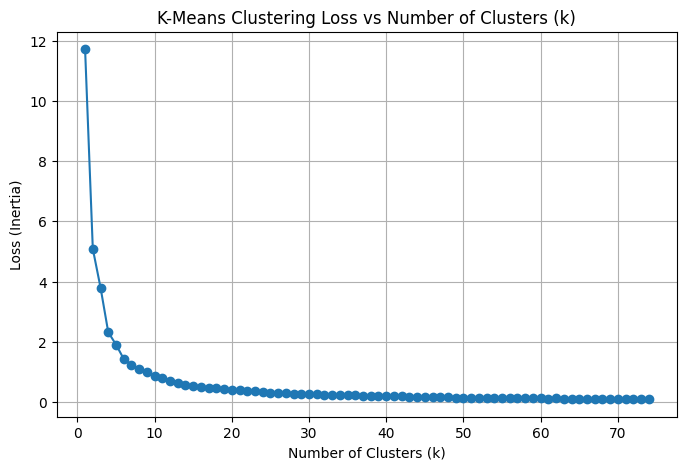

In [99]:
# Range of k values to test
k_values = range(1, 75)

# List to store loss (inertia) for each k
losses = []

x = list(station_dict.values())
# Fit KMeans for each k and record the loss
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    losses.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, losses, marker='o')
plt.title('K-Means Clustering Loss vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Loss (Inertia)')
plt.grid(True)
plt.show()

In [91]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(list(station_dict.values()))
print(kmeans.cluster_centers_)

[[ 40.76839241 -73.97142342]
 [ 40.66521754 -73.95050144]
 [ 40.81741693 -73.93450786]
 [ 40.75105783 -73.87649742]
 [ 40.72653288 -73.99584257]
 [ 40.69691898 -73.91474559]
 [ 40.75761162 -73.9192198 ]
 [ 40.66779842 -73.99535174]
 [ 40.85183941 -73.9036235 ]
 [ 40.71259277 -73.95351088]]


In [95]:
a = set(station_dict.keys())
count = sum(1 for x in kmeans.cluster_centers_ if tuple(x) in a)
print(count)

0
